In [25]:

import pandas as pd
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score
from random import shuffle
import warnings
import time
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import os

In [26]:
NUM_EMBARALHAMENTOS = 4
NUM_PARTES_DATASET = 5
NUM_REPETICOES_POR_PARTE = 5

rng = np.random.RandomState()

In [27]:
def carregar_dataset_mushroom():
    column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 
    'stalk-surface-below-ring', 'stalk-color-above-ring', 
    'stalk-color-below-ring', 'veil-type', 'veil-color',
    'ring-number', 'ring-type', 'spore-print-color', 
    'population', 'habitat'
    ]

    df = pd.read_csv('agaricus-lepiota.data', names=column_names, na_values = '?')
    print(f"Dataset carregado: {df.shape[0]} amostras, {df.shape[1]} colunas")
    return df

In [28]:
def processar_dataset(df):
    print("Processando dataset...")
    target_column = 'class' # Define a coluna alvo

    # --- 1. Limpeza de Dados ---
    # Remove linhas com valores faltando do dataframe inteiro
    df_clean = df.dropna().copy()
    print(f"Dataset após limpeza: {len(df_clean)} amostras.")

    # --- 2. Codificação Categórica (Features e Alvo) ---
    # Identifica colunas categóricas, incluindo a coluna alvo
    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    print(f"Convertendo {len(categorical_columns)} colunas categóricas...")
    
    encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col])
        encoders[col] = le

    # --- 3. Separação de Features (X) e Alvo (y) ---
    X = df_clean.drop(columns=[target_column])
    y = df_clean[target_column]

    # --- 4. Normalização (apenas nas features X) ---
    print("Aplicando normalização Min-Max...")
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    
    print("Features normalizadas para o intervalo [0, 1].")
    print("Dataset processado.")
    
    # Retorna as features normalizadas (array numpy) e o alvo (série pandas)
    return X_normalized, y.values

In [29]:
def preparar_dados_ml(df):
    print(f"\n Preparando dados para Cross Validation...")
    print(f"   Configuração: {NUM_EMBARALHAMENTOS} embaralhamentos × {NUM_PARTES_DATASET} partes × {NUM_REPETICOES_POR_PARTE} repetições")
    print(f"   Divisão treino/teste: 80%/20% (cada parte de 20% vira teste)")
    print(f"   Total de avaliações por algoritmo: {NUM_EMBARALHAMENTOS * NUM_PARTES_DATASET * NUM_REPETICOES_POR_PARTE}")
    return df

In [30]:


def get_cv_results_to_csv(X_data, y_data):
    """
    Executa a validação cruzada e retorna os resultados como um DataFrame.
    """
    total_samples = len(y_data)
    part_size = total_samples // NUM_PARTES_DATASET
    
    # 1. Criar uma lista para armazenar todos os resultados individuais
    all_results = []
    
    print(f"   Divisão: {NUM_PARTES_DATASET} partes de ~{part_size} amostras cada (20% teste, 80% treino)")
    
    for parte_id in range(NUM_PARTES_DATASET):
        print(f" -- Parte {parte_id + 1}/{NUM_PARTES_DATASET} --")
        
        inicio_teste = parte_id * part_size
        fim_teste = (parte_id + 1) * part_size if parte_id != NUM_PARTES_DATASET - 1 else total_samples
            
        xte = X_data[inicio_teste:fim_teste]
        yte = y_data[inicio_teste:fim_teste]
        
        xtr = np.concatenate((X_data[:inicio_teste], X_data[fim_teste:]))
        ytr = np.concatenate((y_data[:inicio_teste], y_data[fim_teste:]))
        
        print(f" Treino: {len(xtr)} amostras | Teste: {len(xte)} amostras") 
        
        for repeticao in range(NUM_REPETICOES_POR_PARTE):
            if NUM_REPETICOES_POR_PARTE > 10 and (repeticao + 1) % 5 == 0:
                print(f"   Repetição {repeticao + 1}/{NUM_REPETICOES_POR_PARTE}")

            cltfs = {
                'perceptron':   Perceptron(max_iter=1000, random_state=rng),
                'svm':          SVC(probability=True, gamma='auto', random_state=rng),
                'bayes':        GaussianNB(),
                'trees':        DecisionTreeClassifier(random_state=rng, max_depth=10),
                'knn':          KNeighborsClassifier(n_neighbors=7)
            }
            
            for clf_name, classifier in cltfs.items():
                inicio = time.time()
                
                classifier.fit(xtr, ytr)
                ypred = classifier.predict(xte)
                f1 = f1_score(yte, ypred, average='macro', zero_division=0)
                accuracy = accuracy_score(yte, ypred)
                
                fim = time.time()
                tempo = fim - inicio

                # 2. Criar um dicionário para a execução atual e adicioná-lo à lista
                result_row = {
                    'Parte': parte_id + 1,
                    'Repeticao': repeticao + 1,
                    'Classificador': clf_name,
                    'F1_Score': f1,
                    'Acuracia': accuracy,
                    'Tempo_Execucao': tempo
                }
                all_results.append(result_row)
                
                # O print da primeira repetição pode ser mantido para feedback
                if repeticao == 0:
                    print(f" {clf_name:<12}: F1 = {f1:.4f} | Acurácia = {accuracy:.4f} | Tempo = {tempo:.3f}s")
        
        print("-" * 60) # Separador visual entre as partes

    print(f"Resumo das {NUM_PARTES_DATASET} partes executadas com sucesso.")

    # 3. Converter a lista de resultados em um DataFrame do Pandas
    results_df = pd.DataFrame(all_results)
    return results_df

In [31]:
def get_cv_value(X_data, y_data):
    """
    Executa a validação cruzada e retorna dois dicionários com F1 e Accuracy.
    """
    total_samples = len(y_data)
    part_size = total_samples // NUM_PARTES_DATASET
    
    # Dicionários para armazenar resultados por algoritmo
    results_f1 = {'perceptron': [], 'svm': [], 'bayes': [], 'trees': [], 'knn': []}
    results_accuracy = {'perceptron': [], 'svm': [], 'bayes': [], 'trees': [], 'knn': []}
    
    print(f"   Divisão: {NUM_PARTES_DATASET} partes de ~{part_size} amostras cada (20% teste, 80% treino)")
    
    for parte_id in range(NUM_PARTES_DATASET):
        print(f" -- Parte {parte_id + 1}/{NUM_PARTES_DATASET} --")
        
        inicio_teste = parte_id * part_size
        fim_teste = (parte_id + 1) * part_size if parte_id != NUM_PARTES_DATASET - 1 else total_samples
            
        xte = X_data[inicio_teste:fim_teste]
        yte = y_data[inicio_teste:fim_teste]
        
        xtr = np.concatenate((X_data[:inicio_teste], X_data[fim_teste:]))
        ytr = np.concatenate((y_data[:inicio_teste], y_data[fim_teste:]))
        
        print(f" Treino: {len(xtr)} amostras | Teste: {len(xte)} amostras") 
        
        for repeticao in range(NUM_REPETICOES_POR_PARTE):
            if NUM_REPETICOES_POR_PARTE > 10 and (repeticao + 1) % 5 == 0:
                print(f"   Repetição {repeticao + 1}/{NUM_REPETICOES_POR_PARTE}")

            cltfs = {
                'perceptron': Perceptron(max_iter=1000, random_state=rng),
                'svm': SVC(probability=True, gamma='auto', random_state=rng),
                'bayes': GaussianNB(),
                'trees': DecisionTreeClassifier(random_state=rng, max_depth=10),
                'knn': KNeighborsClassifier(n_neighbors=7)
            }
            
            for clf_name, classifier in cltfs.items():
                classifier.fit(xtr, ytr)
                ypred = classifier.predict(xte)
                f1 = f1_score(yte, ypred, average='macro', zero_division=0)
                accuracy = accuracy_score(yte, ypred)
                
                results_f1[clf_name].append(f1)
                results_accuracy[clf_name].append(accuracy)
                
                # Print apenas na primeira repetição para feedback
                if repeticao == 0:
                    print(f" {clf_name:<12}: F1 = {f1:.4f} | Acurácia = {accuracy:.4f}")
        
        print("-" * 60)

    print(f"Resumo das {NUM_PARTES_DATASET} partes executadas com sucesso.")
    return results_f1, results_accuracy

In [32]:
def executar_experimentos(x, y):
    print(f"\n EXECUTANDO {NUM_EMBARALHAMENTOS} EMBARALHAMENTOS DO DATASET")
    print("="*80)
    
    all_results_f1 = {
        'perceptron': [],
        'svm': [],
        'bayes': [],
        'trees': [],
        'knn': []
    }

    all_results_accuracy = {
        'perceptron': [],
        'svm': [],
        'bayes': [],
        'trees': [],
        'knn': []
    }

    warnings.filterwarnings('ignore')
    
    for embaralhamento_id in range(NUM_EMBARALHAMENTOS):
        print(f"\n--- EMBARALHAMENTO {embaralhamento_id + 1}/{NUM_EMBARALHAMENTOS} ---")
        
        idx = list(range(len(y)))
        shuffle(idx)
        x_shuffled = x[idx]
        y_shuffled = y[idx]
        
        fold_results_f1, fold_results_accuracy = get_cv_value(x_shuffled, y_shuffled)
        
        for clf_name in fold_results_f1.keys():
            for resultado_f1 in fold_results_f1[clf_name]:
                all_results_f1[clf_name].append(resultado_f1)
            
            for resultado_accuracy in fold_results_accuracy[clf_name]:
                all_results_accuracy[clf_name].append(resultado_accuracy)
        
        print(f" Embaralhamento {embaralhamento_id + 1} concluído! (5 execuções adicionadas)")
        
    warnings.filterwarnings('default')
    
    return all_results_f1, all_results_accuracy

In [33]:
def calcular_estatisticas(all_results):
    print(f"\n ESTATÍSTICAS FINAIS - {NUM_EMBARALHAMENTOS} EMBARALHAMENTOS")
    print("="*70)
    
    estatisticas = {}
    
    print(f"{'Algoritmo':<12} | {'Embaralho 1':<10} | {'Embaralho 2':<10} | {'Embaralho 3':<10} | {'Média Final':<10} | {'Desvio':<8}")
    print("-" * 78)
    
    for clf_name in all_results.keys():
        scores = all_results[clf_name] 
        
        media_final = np.mean(scores)
        desvio = np.std(scores) if len(scores) > 1 else 0.0
        
        estatisticas[clf_name] = {
            'media_final': media_final,
            'desvio': desvio,
            'scores': scores,
            'num_execucoes': len(scores)
        }
        
        if len(scores) >= 3:
            print(f"{clf_name:<12} | {scores[0]:<10.4f} | {scores[1]:<10.4f} | {scores[2]:<10.4f} | {media_final:<10.4f} | {desvio:<8.4f}")
        else:
            scores_str = " | ".join([f"{score:<10.4f}" for score in scores])
            print(f"{clf_name:<12} | {scores_str:<32} | {media_final:<10.4f} | {desvio:<8.4f}")
    
    return estatisticas


In [34]:
def exibir_ranking(estatisticas):
    print(f"\n RANKING FINAL")
    print("="*50)
    
    ranking = sorted(estatisticas.items(), key=lambda x: x[1]['media_final'], reverse=True)

    medalhas = [" 1º", " 2º", " 3º", " 4º", " 5º"]

    for i, (nome, stats) in enumerate(ranking):
        medalha = medalhas[i] if i < len(medalhas) else f"   {i+1}º"
        print(f"{medalha} {nome:<12}: {stats['media_final']:.4f} (±{stats['desvio']:.4f})")
    
    total_avaliacoes = NUM_EMBARALHAMENTOS * NUM_PARTES_DATASET * NUM_REPETICOES_POR_PARTE
    print(f"\nResumo: {NUM_EMBARALHAMENTOS} embaralh × {NUM_PARTES_DATASET} partes × {NUM_REPETICOES_POR_PARTE} repet/parte = {total_avaliacoes} avaliações por algoritmo")


In [35]:
def salvar_resultados_csv(all_results_f1, all_results_accuracy, estatisticas):
    """
    Salva resultados no formato: 23 colunas, 10 linhas
    Formato: nome_dataset, nome_classificador, metrica, resultado_1, ..., resultado_20
    """
    filename = "resultados_ml_compilado.csv"
    
    print(f"\n Salvando resultados em {filename}...")
    
    # Verificar se temos exatamente 20 resultados
    total_execucoes = len(all_results_f1[list(all_results_f1.keys())[0]])
    if total_execucoes != 20:
        print(f"⚠️  AVISO: Esperado 20 resultados, encontrado {total_execucoes}")
    
    # Criar cabeçalho
    header = ['nome_dataset', 'nome_classificador', 'metrica'] + [f'resultado_{i+1}' for i in range(20)]
    
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        
        # Escrever cabeçalho
        writer.writerow(header)
        
        # Escrever dados para cada algoritmo (ordem fixa)
        algoritmos = ['perceptron', 'svm', 'bayes', 'trees', 'knn']
        
        for clf_name in algoritmos:
            # Linha F1-Score (garantir exatamente 20 valores)
            f1_valores = all_results_f1[clf_name][:20]
            f1_linha = ['Mushroom', clf_name, 'f1_score'] + f1_valores
            writer.writerow(f1_linha)
            
            # Linha Accuracy (garantir exatamente 20 valores)
            acc_valores = all_results_accuracy[clf_name][:20]
            acc_linha = ['Mushroom', clf_name, 'accuracy'] + acc_valores
            writer.writerow(acc_linha)
    
    print(f"✅ CSV salvo: {filename}")
    print(f"   📊 Formato: 10 linhas × 23 colunas")
    print(f"   🎯 20 resultados por algoritmo/métrica")
    
    return filename

In [36]:

# ===== VISUALIZAÇÕES COM MATPLOTLIB =====
def criar_visualizacoes(all_results_f1, all_results_accuracy, estatisticas):
    print(f"\n Gerando 2 boxplots (F1-Score e Acurácia)...")
    
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (15, 6)
    plt.rcParams['font.size'] = 11
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    algoritmos_nomes = list(all_results_f1.keys())
    cores = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
    
    # ===== BOXPLOT 1: F1-SCORE =====
    dados_f1 = [all_results_f1[nome] for nome in algoritmos_nomes]
    
    box1 = ax1.boxplot(dados_f1, labels=algoritmos_nomes, patch_artist=True)
    
    # Colorir caixas F1-Score
    for patch, cor in zip(box1['boxes'], cores):
        patch.set_facecolor(cor)
        patch.set_alpha(0.7)
    
    ax1.set_title(' Distribuição F1-Score por Algoritmo', fontsize=13, fontweight='bold', pad=20)
    ax1.set_xlabel('Algoritmos', fontweight='bold')
    ax1.set_ylabel('F1-Score', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # ===== BOXPLOT 2: ACURÁCIA =====
    dados_accuracy = [all_results_accuracy[nome] for nome in algoritmos_nomes]
    
    box2 = ax2.boxplot(dados_accuracy, labels=algoritmos_nomes, patch_artist=True)
    
    # Colorir caixas Acurácia (cores mais escuras)
    cores_accuracy = ['steelblue', 'forestgreen', 'indianred', 'orange', 'mediumvioletred']
    for patch, cor in zip(box2['boxes'], cores_accuracy):
        patch.set_facecolor(cor)
        patch.set_alpha(0.7)
    
    ax2.set_title(' Distribuição Acurácia por Algoritmo', fontsize=13, fontweight='bold', pad=20)
    ax2.set_xlabel('Algoritmos', fontweight='bold')
    ax2.set_ylabel('Acurácia', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Ajustar layout
    plt.tight_layout()
    
    # Salvar figura
    plt.savefig('boxplots_comparacao.png', dpi=300, bbox_inches='tight')
    print(f"     Boxplots salvos: boxplots_comparacao.png")
    
    # Mostrar gráfico
    plt.show()
    
    print(f"     Visualizações concluídas!")


 EXERCÍCIO: COMPARAÇÃO DE ALGORITMOS ML - CROSS VALIDATION SEQUENCIAL
  Configuração: 4 embaralhamentos × 5 partes × 5 repetições/parte
 Total de avaliações por algoritmo: 100
Dataset carregado: 8124 amostras, 23 colunas
Processando dataset...
Dataset após limpeza: 5644 amostras.
Convertendo 23 colunas categóricas...
Aplicando normalização Min-Max...
Features normalizadas para o intervalo [0, 1].
Dataset processado.

 Preparando dados para Cross Validation...
   Configuração: 4 embaralhamentos × 5 partes × 5 repetições
   Divisão treino/teste: 80%/20% (cada parte de 20% vira teste)
   Total de avaliações por algoritmo: 100

 EXECUTANDO 4 EMBARALHAMENTOS DO DATASET

--- EMBARALHAMENTO 1/4 ---
   Divisão: 5 partes de ~1128 amostras cada (20% teste, 80% treino)
 -- Parte 1/5 --
 Treino: 4516 amostras | Teste: 1128 amostras
 perceptron  : F1 = 0.9616 | Acurácia = 0.9645


 svm         : F1 = 0.9694 | Acurácia = 0.9716
 bayes       : F1 = 0.5055 | Acurácia = 0.6622
 trees       : F1 = 1.0000 | Acurácia = 1.0000
 knn         : F1 = 1.0000 | Acurácia = 1.0000
------------------------------------------------------------
 -- Parte 2/5 --
 Treino: 4516 amostras | Teste: 1128 amostras
 perceptron  : F1 = 0.9695 | Acurácia = 0.9725
 svm         : F1 = 0.9745 | Acurácia = 0.9770
 bayes       : F1 = 0.5157 | Acurácia = 0.6871
 trees       : F1 = 1.0000 | Acurácia = 1.0000
 knn         : F1 = 1.0000 | Acurácia = 1.0000
------------------------------------------------------------
 -- Parte 3/5 --
 Treino: 4516 amostras | Teste: 1128 amostras
 perceptron  : F1 = 0.9676 | Acurácia = 0.9699
 svm         : F1 = 0.9600 | Acurácia = 0.9628
 bayes       : F1 = 0.5140 | Acurácia = 0.6622
 trees       : F1 = 1.0000 | Acurácia = 1.0000
 knn         : F1 = 1.0000 | Acurácia = 1.0000
------------------------------------------------------------
 -- Parte 4/5 --
 Treino: 4516 am

/tmp/ipykernel_5040/2888926686.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box1 = ax1.boxplot(dados_f1, labels=algoritmos_nomes, patch_artist=True)
/tmp/ipykernel_5040/2888926686.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box2 = ax2.boxplot(dados_accuracy, labels=algoritmos_nomes, patch_artist=True)


     Boxplots salvos: boxplots_comparacao.png


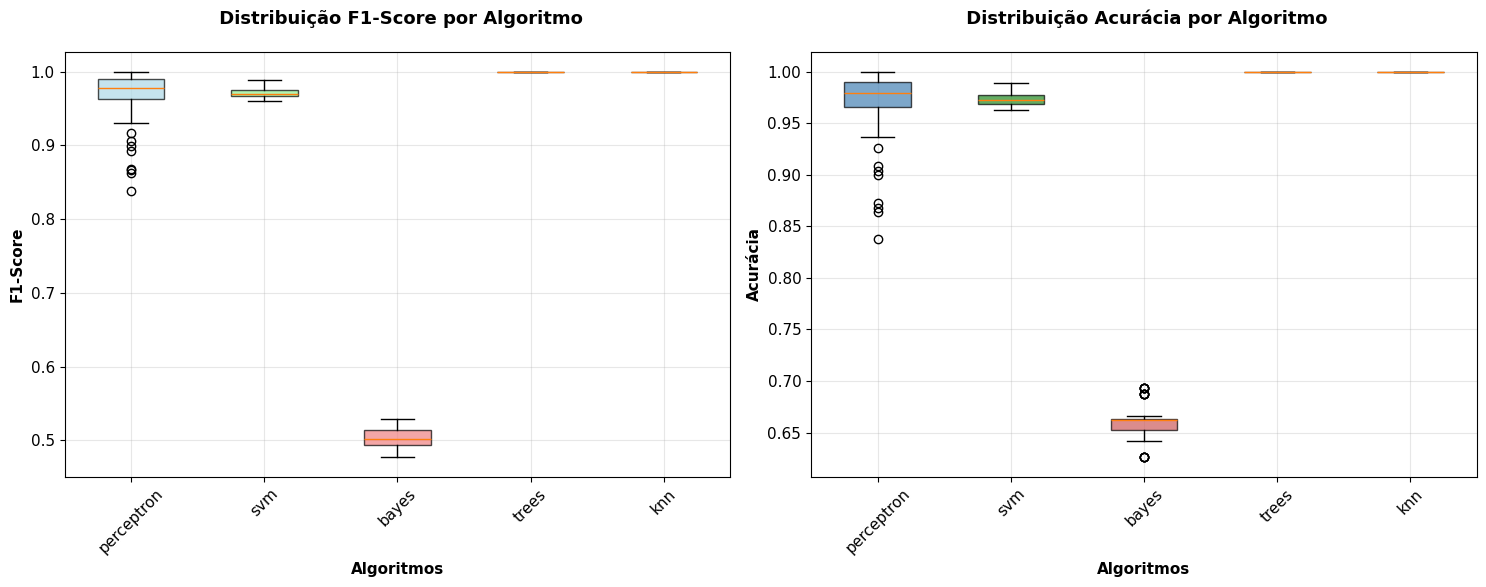

     Visualizações concluídas!

 EXPERIMENTO CONCLUÍDO COM SUCESSO!


In [37]:

def main():
    print(" EXERCÍCIO: COMPARAÇÃO DE ALGORITMOS ML - CROSS VALIDATION SEQUENCIAL")
    print("="*70)
    print(f"  Configuração: {NUM_EMBARALHAMENTOS} embaralhamentos × {NUM_PARTES_DATASET} partes × {NUM_REPETICOES_POR_PARTE} repetições/parte")
    print(f" Total de avaliações por algoritmo: {NUM_EMBARALHAMENTOS * NUM_PARTES_DATASET * NUM_REPETICOES_POR_PARTE}")
    print("="*70)
    
    try:
        # Carregar dados
        df = carregar_dataset_mushroom()
        
        # Processar e normalizar (inclui Min-Max)
        X, y = processar_dataset(df)
        
        # Validação prévia
        preparar_dados_ml(X)
        
        # Executar cross validation manual
        all_results_f1, all_results_accuracy = executar_experimentos(X, y)
        
        # Calcular e exibir estatísticas
        estatisticas = calcular_estatisticas(all_results_f1)
        
        # Exibir ranking final
        exibir_ranking(estatisticas)
        
        # Salvar resultados em CSV
        salvar_resultados_csv(all_results_f1, all_results_accuracy, estatisticas)
        
        #  Gerar visualizações (2 boxplots)
        criar_visualizacoes(all_results_f1, all_results_accuracy, estatisticas)
        
        print(f"\n EXPERIMENTO CONCLUÍDO COM SUCESSO!")
        print("="*70)
        
    except Exception as e:
        print(f" ERRO durante execução: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()
